In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, feats, strategies, models_core
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import os
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)
# df_trainval

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds_trainval = pd.read_csv(params.indunsc_test_csv, index_col=0, parse_dates=True) ###############
df_inds_trainval = df_inds_trainval[df_inds_trainval.index.to_period("M") == params.month_to_check] ################################
# compute synthetic ask/bid from close_raw and configured spread
df_inds_trainval['ask'] = df_inds_trainval['close'] * (1 + params.bidask_spread_pct/100)
df_inds_trainval['bid'] = df_inds_trainval['close'] * (1 - params.bidask_spread_pct/100)

df_inds_trainval

,open,high,low,close,volume,signal,ret,log_ret,sma_9,sma_21,sma_pct_9,sma_pct_21,ema_9,ema_21,roc_9,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,macd_line,macd_signal,macd_diff,atr_14,atr_pct_14,bb_lband_20,bb_hband_20,bb_w_20,plus_di,minus_di,adx,obv,vwap_14,vwap_dev_pct_14,vol_spike,vol_z_14,rolling_max_close_21,rolling_min_close_21,dist_high_21,dist_low_21,obv_sma,obv_diff_14,obv_pct_14,obv_sma_14,obv_z_14,ret_30,sma_30,sma_pct_30,ema_30,roc_30,rsi_30,atr_30,atr_pct_30,bb_lband_30,bb_hband_30,bb_w_30,plus_di_30,minus_di_30,adx_30,obv_diff_30,obv_pct_30,obv_sma_30,obv_z_30,vwap_30,vwap_dev_pct_30,z_vwap_dev_30,vol_spike_30,vol_z_30,ret_std_30,rolling_max_close_30,rolling_min_close_30,dist_high_30,dist_low_30,macd_line_30,macd_signal_30,macd_diff_30,ret_45,sma_45,sma_pct_45,ema_45,roc_45,rsi_45,atr_45,atr_pct_45,bb_lband_45,bb_hband_45,bb_w_45,plus_di_45,minus_di_45,adx_45,obv_diff_45,obv_pct_45,obv_sma_45,obv_z_45,vwap_45,vwap_dev_pct_45,z_vwap_dev_45,vol_spike_45,vol_z_45,ret_std_45,rolling_max_close_45,rolling_min_close_45,dist_high_45,dist_low_45,macd_line_45,macd_signal_45,macd_diff_45,ret_60,sma_60,sma_pct_60,ema_60,roc_60,rsi_60,atr_60,atr_pct_60,bb_lband_60,bb_hband_60,bb_w_60,plus_di_60,minus_di_60,adx_60,obv_diff_60,obv_pct_60,obv_sma_60,obv_z_60,vwap_60,vwap_dev_pct_60,z_vwap_dev_60,vol_spike_60,vol_z_60,ret_std_60,rolling_max_close_60,rolling_min_close_60,dist_high_60,dist_low_60,macd_line_60,macd_signal_60,macd_diff_60,volume_z_30,vol_spike_z_30,ret_std_z_30,obv_pct_z_30,vwap_dev_pct_z_30,bb_w_z_30,atr_z_30,macd_diff_z_30,volume_z_45,vol_spike_z_45,ret_std_z_45,obv_pct_z_45,vwap_dev_pct_z_45,bb_w_z_45,atr_z_45,macd_diff_z_45,volume_z_60,vol_spike_z_60,ret_std_z_60,obv_pct_z_60,vwap_dev_pct_z_60,bb_w_z_60,atr_z_60,macd_diff_z_60,minute_time,hour_time,dow_time,month_time,day_of_year_time,week_of_year_time,in_sess_time,eng_ma,eng_macd,eng_bb,eng_bb_mid,eng_rsi,eng_adx,eng_obv,eng_atr_div,z_eng_atr,eng_sma_short,eng_sma_long,eng_vwap,z_vwap_dev,z_bb_w,z_obv,mom_sum_30,mom_std_30,mom_sum_45,mom_std_45,mom_sum_60,mom_std_60,eng_ema_cross_up,eng_ema_cross_down,ask,bid
2024-05-01 10:58:00,169.590,169.59,169.550,169.580,4.0,0.133672,0.000000,0.000000,169.571111,169.499524,0.000052,0.000475,169.563070,169.526795,0.000000,0.000885,-0.010,-0.000059,0.000,0.030,0.000236,59.867729,0.032731,0.023858,0.008873,0.070101,0.000413,169.331635,169.673365,0.002016,28.711850,22.206768,16.604624,9890.0,169.704797,-0.073538,0.027211,-1.064504,169.60,169.350,0.000118,0.001356,9.579071e+03,1328.0,7.832531,9.579071e+03,1.569673,0.000000,169.483333,0.000570,169.515989,0.000000,51.990956,0.079402,0.000468,169.322226,169.644441,0.001901,25.764508,24.644386,11.582342,120.0,0.708034,9.349967e+03,1.103112,169.500320,0.047009,0.754999,0.033370,-0.906301,0.000290,169.60,169.350,0.000118,0.001356,-0.007080,-0.016286,0.009207,0.001417,169.474667,0.000622,169.518405,0.001417,49.924155,0.084961,0.000501,169.316196,169.633137,0.001870,24.013212,25.412423,12.341437,5003.0,29.520636,8.860889e+03,0.702000,169.445514,0.079368,1.583539,0.018306,-0.477063,0.000368,169.60,169.34,0.000118,0.001415,-0.024240,-0.029084,0.004844,-0.001060,169.508333,0.000423,169.534876,-0.001060,48.751132,0.088378,0.000521,169.269275,169.747392,0.002821,23.079682,25.631879,0.000000,801.0,4.725431,8.574633e+03,0.469153,169.507075,0.043022,1.616097,0.013013,-0.534376,0.000365,169.79,169.340,0.001238,0.001415,-0.018445,-0.020490,0.002046,-0.713877,-0.000002,-1.352839,-0.511407,0.676005,0.144213,-1.047574,20.000000,-0.769713,-0.000002,-20.000000,20.000000,20.000000,-20.000000,-2.108465,0.000000,-0.827784,-8.524652e-10,0.000000,0.000000,20.000000,-20.000000,-0.187195,0.000000,0.352778,0.312500,0.785714,0.833333,0.831507,0.826923,0.0,0.000422,0.000052,0.0,-0.000457,0.00000,0.000000,0.142003,-0.319581,-1.569168,-0.000052,-0.000475,-100.043365,0.175647,1.276296,-0.126481,-0.008825,0.001040,-0.037828,0.000898,0.000000,0.000000,1.0,0.0,169.613916,169.546084
2024-05-01 10:59:00,

In [5]:
df = df_inds_trainval # SELECT THE CORRECT DATAFRAME

start = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
end   = df.loc[df.index.normalize() == df.index.normalize().max(),  "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df.index.normalize().nunique()
baseline_pnl

607.1416819090908

In [6]:
# trading_combinations = {
#     "tc_001": {"col_signal":"ema_9",               "sign_thresh":"ema_21"},
#     "tc_002": {"col_signal":"sma_9",               "sign_thresh":"sma_21"},
#     "tc_003": {"col_signal":"close",               "sign_thresh":"ema_9"},
#     "tc_004": {"col_signal":"close",               "sign_thresh":"ema_21"},
#     "tc_005": {"col_signal":"macd_line",            "sign_thresh":"macd_signal"},
#     "tc_006": {"col_signal":"macd_diff",            "sign_thresh":0.0},
#     "tc_007": {"col_signal":"dist_low_21",          "sign_thresh":0.0},
#     "tc_008": {"col_signal":"dist_high_21",         "sign_thresh":0.0},
#     "tc_009": {"col_signal":"sma_pct_9",            "sign_thresh":0.0},
#     "tc_010": {"col_signal":"sma_pct_21",           "sign_thresh":0.0},
#     "tc_011": {"col_signal":"roc_9",                "sign_thresh":0.0},
#     "tc_012": {"col_signal":"roc_21",               "sign_thresh":0.0},
#     "tc_013": {"col_signal":"vwap_dev_pct_14",      "sign_thresh":0.0},
#     "tc_014": {"col_signal":"obv_pct_14",           "sign_thresh":0.0},
#     "tc_015": {"col_signal":"vol_spike",            "sign_thresh":1.0},
#     "tc_016": {"col_signal":"rolling_max_close_21", "sign_thresh":"dist_high_21"},
#     "tc_017": {"col_signal":"rolling_min_close_21", "sign_thresh":"dist_low_21"},
#     "tc_018": {"col_signal":"obv_sma",              "sign_thresh":"obv_sma_14"},
#     "tc_019": {"col_signal":"obv_diff_14",          "sign_thresh":0.0},
#     "tc_020": {"col_signal":"obv_z_14",             "sign_thresh":0.0},
#     "tc_021": {"col_signal":"body_pct",             "sign_thresh":0.0},
#     "tc_022": {"col_signal":"upper_shad",           "sign_thresh":"range_pct"},
#     "tc_023": {"col_signal":"lower_shad",           "sign_thresh":"range_pct"},
#     "tc_024": {"col_signal":"plus_di",              "sign_thresh":"minus_di"},
#     "tc_025": {"col_signal":"adx",                  "sign_thresh":20.0},
#     "tc_026": {"col_signal":"bb_w_20",              "sign_thresh":0.0},
#     "tc_027": {"col_signal":"atr_14",               "sign_thresh":"atr_pct_14"},
#     "tc_028": {"col_signal":"atr_pct_14",           "sign_thresh":0.0},
#     "tc_029": {"col_signal":"ret",                  "sign_thresh":0.0},
#     "tc_030": {"col_signal":"log_ret",              "sign_thresh":0.0},
#     "tc_031": {"col_signal":"ema_9",               "sign_thresh":"vwap_dev_pct_14"},
#     "tc_032": {"col_signal":"sma_9",               "sign_thresh":"vwap_dev_pct_14"},
#     "tc_033": {"col_signal":"macd_line",            "sign_thresh":"ema_9"},
#     "tc_034": {"col_signal":"macd_line",            "sign_thresh":"ema_21"},
#     "tc_035": {"col_signal":"sma_pct_9",            "sign_thresh":"sma_pct_21"},
#     "tc_036": {"col_signal":"vwap_dev_pct_14",      "sign_thresh":"sma_pct_9"},
#     "tc_037": {"col_signal":"roc_9",                "sign_thresh":"ema_21"},
#     "tc_038": {"col_signal":"vol_z_14",             "sign_thresh":1.5},
#     "tc_039": {"col_signal":"rolling_min_close_21", "sign_thresh":"ema_9"},
#     "tc_040": {"col_signal":"rolling_max_close_21", "sign_thresh":"ema_21"},
#     "tc_041": {"col_signal":"obv_pct_14",           "sign_thresh":"obv_sma_14"},
#     "tc_042": {"col_signal":"obv_diff_14",          "sign_thresh":"obv_sma_14"},
#     "tc_043": {"col_signal":"body",                 "sign_thresh":0.0},
#     "tc_044": {"col_signal":"range_pct",            "sign_thresh":0.0},
#     "tc_045": {"col_signal":"ema_9",               "sign_thresh":"sma_21"},
#     "tc_046": {"col_signal":"sma_9",               "sign_thresh":"ema_21"},
#     "tc_047": {"col_signal":"bb_w_20",              "sign_thresh":"roc_9"},
#     "tc_048": {"col_signal":"vwap_dev_pct_14",      "sign_thresh":"roc_9"},
# }


# replace zero thresholds with a tiny epsilon to avoid divide-by-zero
_eps = 1e-9
trading_combinations = {
    "tc_001": {"col_signal": "ema_9",               "sign_thresh": "ema_21"},
    "tc_002": {"col_signal": "sma_9",               "sign_thresh": "sma_21"},
    # "tc_003": {"col_signal": "close",               "sign_thresh": "ema_9"},
    # "tc_004": {"col_signal": "close",               "sign_thresh": "ema_21"},
    # "tc_005": {"col_signal": "macd_line",           "sign_thresh": "macd_signal"},
    # "tc_006": {"col_signal": "macd_diff",           "sign_thresh": _eps},
    # "tc_007": {"col_signal": "dist_low_21",         "sign_thresh": _eps},
    # "tc_008": {"col_signal": "dist_high_21",        "sign_thresh": _eps},
    # "tc_009": {"col_signal": "sma_pct_9",           "sign_thresh": _eps},
    # "tc_010": {"col_signal": "sma_pct_21",          "sign_thresh": _eps},
    # "tc_011": {"col_signal": "roc_9",               "sign_thresh": _eps},
    # "tc_012": {"col_signal": "roc_21",              "sign_thresh": _eps},
    # "tc_013": {"col_signal": "vwap_dev_pct_14",     "sign_thresh": _eps},
    # "tc_014": {"col_signal": "obv_pct_14",          "sign_thresh": "obv_sma_14"},
    # "tc_015": {"col_signal": "vol_spike",           "sign_thresh": 1.0},
    # "tc_016": {"col_signal": "rolling_max_close_21","sign_thresh": "dist_high_21"},
    # "tc_017": {"col_signal": "rolling_min_close_21","sign_thresh": "dist_low_21"},
    # "tc_018": {"col_signal": "obv_sma",             "sign_thresh": "obv_sma_14"},
    # "tc_019": {"col_signal": "vol_z_14",            "sign_thresh": 1.5},
    # "tc_020": {"col_signal": "adx",                 "sign_thresh": 20.0},
    # "tc_021": {"col_signal": "plus_di",             "sign_thresh": "minus_di"},
    # "tc_022": {"col_signal": "atr_pct_14",          "sign_thresh": _eps},
    # "tc_023": {"col_signal": "body_pct",            "sign_thresh": _eps},
    # "tc_024": {"col_signal": "range_pct",           "sign_thresh": _eps},
}



In [7]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:

    trad_comb     = trading_combinations[trial.suggest_categorical("tc_id", list(trading_combinations.keys()))]
    reset_peak    = trial.suggest_categorical("reset_peak", [True, False]) 
    rsi_thresh    = trial.suggest_int("rsi_thresh", 30, 75)
    atr_mult      = trial.suggest_float("atr_mult", 0.1, 6.0, log=True)
    vwap_atr_mult = trial.suggest_float("vwap_atr_mult", -4.0, 4.0, log=False)
    invest_frac   = trial.suggest_float("invest_frac", 0.05, 0.95, log=True)
    buy_factor    = trial.suggest_float("buy_factor", 0.05, 0.95, log=True)
    sell_factor   = trial.suggest_float("sell_factor", 0.05, 0.95, log=True)
    trailstop_pct = trial.suggest_float("trailstop_pct", 0.01, 0.30, log=True)
    sess_start    = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat(), params.sess_start_reg.isoformat()]))

    print('-' * 150)
    print(f"Params => trad_comb={trad_comb}, reset_peak={reset_peak}, rsi_thresh={rsi_thresh:.3f}, atr_mult={atr_mult:.3f}, vwap_atr_mult={vwap_atr_mult:.3f}, invest_frac={invest_frac:.3f}, buy_factor={buy_factor:.3f}, sell_factor={sell_factor:.3f}, trailstop_pct={trailstop_pct:.3f}, sess_start={sess_start}")

    strategies.reset_globals() # necessary to correctly reset the global variables before each independent simulation
    daily_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strategies.generate_tradact_elab(
            df              = df_day,
            col_signal      = trad_comb["col_signal"],
            sign_thresh     = trad_comb["sign_thresh"],
            col_atr         = "atr_14",
            col_rsi         = "rsi_6",
            col_vwap        = "vwap_14",
            reset_peak      = reset_peak,
            rsi_thresh      = rsi_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            sess_start      = sess_start
        )

        sim_results = strategies.simulate_trading(
            day             = day,
            df              = df_actions,
            invest_frac     = invest_frac,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
            sess_start      = sess_start
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))
        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        # strategy_val = float(_findall(stats["STRATEGY"])[-1])
        daily_pnls.append(plots._parse_eq_value(stats['STRATEGY']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        # Report for pruning
        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(daily_pnls))
            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = float(__import__("numpy").percentile(vals, prun_perc))
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    mean_pnl = float(np.mean(daily_pnls))

    return mean_pnl


In [8]:
# import torch
# targets = {"generate_tradact_elab","simulate_trading","fees_for_one_share","_format_perf","_parse_eq_value"}
# print([n for n in dir(torch.ops) if n in targets])


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, rsi_thresh=55.000, atr_mult=0.349, vwap_atr_mult=-2.797, invest_frac=0.338, buy_factor=0.127, sell_factor=0.508, trailstop_pct=0.027, sess_start=14:30:00


Trial 0: 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]


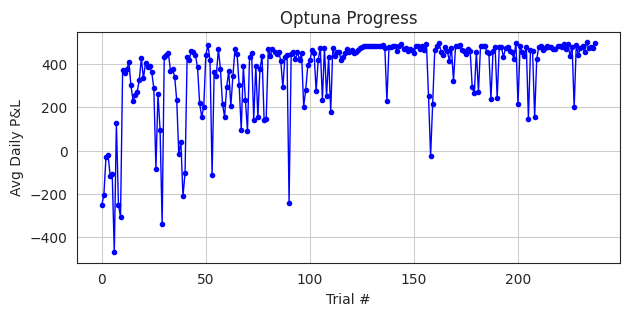

[Results] Trial 0 finished with value: -251.0949. Improvement over baseline: -141.36%.     Best is trial 0 with value: -251.0949.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=40.000, atr_mult=0.153, vwap_atr_mult=-1.553, invest_frac=0.876, buy_factor=0.510, sell_factor=0.187, trailstop_pct=0.039, sess_start=14:30:00


Trial 1: 100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


[Results] Trial 1 finished with value: -204.2813. Improvement over baseline: -133.65%.     Best is trial 1 with value: -204.2813.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, rsi_thresh=73.000, atr_mult=0.109, vwap_atr_mult=-2.350, invest_frac=0.079, buy_factor=0.130, sell_factor=0.121, trailstop_pct=0.139, sess_start=14:30:00


Trial 2: 100%|██████████| 22/22 [00:08<00:00,  2.55it/s]


[Results] Trial 2 finished with value: -30.3570. Improvement over baseline: -105.00%.     Best is trial 2 with value: -30.3570.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=62.000, atr_mult=0.589, vwap_atr_mult=-1.189, invest_frac=0.062, buy_factor=0.136, sell_factor=0.248, trailstop_pct=0.019, sess_start=14:30:00


Trial 3: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s]


[Results] Trial 3 finished with value: -19.7672. Improvement over baseline: -103.26%.     Best is trial 3 with value: -19.7672.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=35.000, atr_mult=2.750, vwap_atr_mult=-2.305, invest_frac=0.101, buy_factor=0.079, sell_factor=0.564, trailstop_pct=0.011, sess_start=13:30:00


Trial 4: 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]


[Results] Trial 4 finished with value: -115.3911. Improvement over baseline: -119.01%.     Best is trial 3 with value: -19.7672.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=38.000, atr_mult=0.138, vwap_atr_mult=-1.996, invest_frac=0.903, buy_factor=0.367, sell_factor=0.156, trailstop_pct=0.188, sess_start=14:30:00


Trial 5: 100%|██████████| 22/22 [00:08<00:00,  2.65it/s]


[Results] Trial 5 finished with value: -109.2660. Improvement over baseline: -118.00%.     Best is trial 3 with value: -19.7672.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_thresh=31.000, atr_mult=1.878, vwap_atr_mult=2.761, invest_frac=0.936, buy_factor=0.447, sell_factor=0.948, trailstop_pct=0.030, sess_start=14:30:00


Trial 6: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s]


[Results] Trial 6 finished with value: -468.6562. Improvement over baseline: -177.19%.     Best is trial 3 with value: -19.7672.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=70.000, atr_mult=0.607, vwap_atr_mult=2.317, invest_frac=0.270, buy_factor=0.063, sell_factor=0.114, trailstop_pct=0.070, sess_start=14:30:00


Trial 7: 100%|██████████| 22/22 [00:05<00:00,  4.36it/s]


[Results] Trial 7 finished with value: 128.2768. Improvement over baseline: -78.87%.     Best is trial 7 with value: 128.2768.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_thresh=48.000, atr_mult=1.554, vwap_atr_mult=3.320, invest_frac=0.311, buy_factor=0.100, sell_factor=0.334, trailstop_pct=0.206, sess_start=13:30:00


Trial 8: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s]


[Results] Trial 8 finished with value: -249.3781. Improvement over baseline: -141.07%.     Best is trial 7 with value: 128.2768.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, rsi_thresh=58.000, atr_mult=0.435, vwap_atr_mult=0.506, invest_frac=0.795, buy_factor=0.132, sell_factor=0.275, trailstop_pct=0.246, sess_start=14:30:00


Trial 9: 100%|██████████| 22/22 [00:04<00:00,  4.90it/s]


[Results] Trial 9 finished with value: -305.8850. Improvement over baseline: -150.38%.     Best is trial 7 with value: 128.2768.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=75.000, atr_mult=4.292, vwap_atr_mult=1.381, invest_frac=0.147, buy_factor=0.887, sell_factor=0.053, trailstop_pct=0.084, sess_start=13:30:00


Trial 10: 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]


[Results] Trial 10 finished with value: 373.3166. Improvement over baseline: -38.51%.     Best is trial 10 with value: 373.3166.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=75.000, atr_mult=5.922, vwap_atr_mult=1.242, invest_frac=0.151, buy_factor=0.924, sell_factor=0.059, trailstop_pct=0.088, sess_start=13:30:00


Trial 11: 100%|██████████| 22/22 [00:08<00:00,  2.75it/s]


[Results] Trial 11 finished with value: 357.9148. Improvement over baseline: -41.05%.     Best is trial 10 with value: 373.3166.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=67.000, atr_mult=5.733, vwap_atr_mult=1.065, invest_frac=0.140, buy_factor=0.902, sell_factor=0.051, trailstop_pct=0.081, sess_start=13:30:00


Trial 12: 100%|██████████| 22/22 [00:04<00:00,  4.66it/s]


[Results] Trial 12 finished with value: 374.4686. Improvement over baseline: -38.32%.     Best is trial 12 with value: 374.4686.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=66.000, atr_mult=5.918, vwap_atr_mult=1.481, invest_frac=0.157, buy_factor=0.896, sell_factor=0.051, trailstop_pct=0.116, sess_start=13:30:00


Trial 13: 100%|██████████| 22/22 [00:03<00:00,  6.26it/s]


[Results] Trial 13 finished with value: 408.5759. Improvement over baseline: -32.71%.     Best is trial 13 with value: 408.5759.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=64.000, atr_mult=1.334, vwap_atr_mult=0.166, invest_frac=0.169, buy_factor=0.261, sell_factor=0.080, trailstop_pct=0.116, sess_start=13:30:00


Trial 14: 100%|██████████| 22/22 [00:04<00:00,  5.36it/s]


[Results] Trial 14 finished with value: 299.9457. Improvement over baseline: -50.60%.     Best is trial 13 with value: 408.5759.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=66.000, atr_mult=3.303, vwap_atr_mult=3.857, invest_frac=0.429, buy_factor=0.638, sell_factor=0.081, trailstop_pct=0.044, sess_start=13:30:00


Trial 15: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s]


[Results] Trial 15 finished with value: 229.1513. Improvement over baseline: -62.26%.     Best is trial 13 with value: 408.5759.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=49.000, atr_mult=5.477, vwap_atr_mult=-3.717, invest_frac=0.104, buy_factor=0.271, sell_factor=0.079, trailstop_pct=0.055, sess_start=13:30:00


Trial 16: 100%|██████████| 22/22 [00:03<00:00,  6.43it/s]


[Results] Trial 16 finished with value: 255.6215. Improvement over baseline: -57.90%.     Best is trial 13 with value: 408.5759.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=68.000, atr_mult=1.020, vwap_atr_mult=-0.668, invest_frac=0.186, buy_factor=0.658, sell_factor=0.104, trailstop_pct=0.131, sess_start=13:30:00


Trial 17: 100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


[Results] Trial 17 finished with value: 270.7565. Improvement over baseline: -55.40%.     Best is trial 13 with value: 408.5759.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=60.000, atr_mult=2.144, vwap_atr_mult=2.085, invest_frac=0.108, buy_factor=0.348, sell_factor=0.055, trailstop_pct=0.062, sess_start=13:30:00


Trial 18: 100%|██████████| 22/22 [00:03<00:00,  6.79it/s]


[Results] Trial 18 finished with value: 324.4912. Improvement over baseline: -46.55%.     Best is trial 13 with value: 408.5759.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=53.000, atr_mult=3.347, vwap_atr_mult=1.228, invest_frac=0.508, buy_factor=0.689, sell_factor=0.072, trailstop_pct=0.280, sess_start=13:30:00


Trial 19: 100%|██████████| 22/22 [00:03<00:00,  5.58it/s]


[Results] Trial 19 finished with value: 425.4881. Improvement over baseline: -29.92%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=46.000, atr_mult=3.465, vwap_atr_mult=-0.454, invest_frac=0.572, buy_factor=0.199, sell_factor=0.142, trailstop_pct=0.267, sess_start=13:30:00


Trial 20: 100%|██████████| 22/22 [00:02<00:00,  7.81it/s]


[Results] Trial 20 finished with value: 332.2901. Improvement over baseline: -45.27%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=52.000, atr_mult=4.449, vwap_atr_mult=0.987, invest_frac=0.215, buy_factor=0.718, sell_factor=0.067, trailstop_pct=0.177, sess_start=13:30:00


Trial 21: 100%|██████████| 22/22 [00:03<00:00,  6.88it/s]


[Results] Trial 21 finished with value: 405.0900. Improvement over baseline: -33.28%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=54.000, atr_mult=2.487, vwap_atr_mult=1.710, invest_frac=0.240, buy_factor=0.598, sell_factor=0.072, trailstop_pct=0.162, sess_start=13:30:00


Trial 22: 100%|██████████| 22/22 [00:05<00:00,  3.89it/s]


[Results] Trial 22 finished with value: 384.2121. Improvement over baseline: -36.72%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=50.000, atr_mult=4.003, vwap_atr_mult=0.759, invest_frac=0.451, buy_factor=0.715, sell_factor=0.102, trailstop_pct=0.297, sess_start=13:30:00


Trial 23: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s]


[Results] Trial 23 finished with value: 389.8319. Improvement over baseline: -35.79%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=57.000, atr_mult=4.180, vwap_atr_mult=-0.037, invest_frac=0.201, buy_factor=0.421, sell_factor=0.068, trailstop_pct=0.103, sess_start=13:30:00


Trial 24: 100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


[Results] Trial 24 finished with value: 360.7805. Improvement over baseline: -40.58%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=44.000, atr_mult=1.096, vwap_atr_mult=2.624, invest_frac=0.382, buy_factor=0.738, sell_factor=0.093, trailstop_pct=0.207, sess_start=13:30:00


Trial 25: 100%|██████████| 22/22 [00:02<00:00,  7.69it/s]


[Results] Trial 25 finished with value: 286.1215. Improvement over baseline: -52.87%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, rsi_thresh=43.000, atr_mult=2.848, vwap_atr_mult=1.847, invest_frac=0.256, buy_factor=0.529, sell_factor=0.066, trailstop_pct=0.159, sess_start=13:30:00


Trial 26: 100%|██████████| 22/22 [00:03<00:00,  6.77it/s]


[Results] Trial 26 finished with value: -84.6182. Improvement over baseline: -113.94%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=53.000, atr_mult=1.852, vwap_atr_mult=0.535, invest_frac=0.534, buy_factor=0.318, sell_factor=0.144, trailstop_pct=0.226, sess_start=13:30:00


Trial 27: 100%|██████████| 22/22 [00:03<00:00,  6.30it/s]


[Results] Trial 27 finished with value: 259.6833. Improvement over baseline: -57.23%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=51.000, atr_mult=0.242, vwap_atr_mult=-0.323, invest_frac=0.687, buy_factor=0.197, sell_factor=0.088, trailstop_pct=0.111, sess_start=13:30:00


Trial 28: 100%|██████████| 22/22 [00:03<00:00,  6.72it/s]


[Results] Trial 28 finished with value: 95.8617. Improvement over baseline: -84.21%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, rsi_thresh=61.000, atr_mult=4.428, vwap_atr_mult=3.090, invest_frac=0.339, buy_factor=0.789, sell_factor=0.191, trailstop_pct=0.171, sess_start=13:30:00


Trial 29: 100%|██████████| 22/22 [00:03<00:00,  6.31it/s]


[Results] Trial 29 finished with value: -338.5694. Improvement over baseline: -155.76%.     Best is trial 19 with value: 425.4881.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=56.000, atr_mult=2.557, vwap_atr_mult=1.724, invest_frac=0.125, buy_factor=0.533, sell_factor=0.063, trailstop_pct=0.281, sess_start=13:30:00


Trial 30: 100%|██████████| 22/22 [00:02<00:00,  7.47it/s]


[Results] Trial 30 finished with value: 432.3741. Improvement over baseline: -28.79%.     Best is trial 30 with value: 432.3741.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=57.000, atr_mult=3.324, vwap_atr_mult=1.398, invest_frac=0.131, buy_factor=0.550, sell_factor=0.064, trailstop_pct=0.254, sess_start=13:30:00


Trial 31: 100%|██████████| 22/22 [00:05<00:00,  4.33it/s]


[Results] Trial 31 finished with value: 440.8098. Improvement over baseline: -27.40%.     Best is trial 31 with value: 440.8098.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=56.000, atr_mult=2.459, vwap_atr_mult=1.576, invest_frac=0.121, buy_factor=0.563, sell_factor=0.051, trailstop_pct=0.289, sess_start=13:30:00


Trial 32: 100%|██████████| 22/22 [00:03<00:00,  7.29it/s]


[Results] Trial 32 finished with value: 448.2954. Improvement over baseline: -26.16%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=57.000, atr_mult=1.487, vwap_atr_mult=2.214, invest_frac=0.117, buy_factor=0.507, sell_factor=0.063, trailstop_pct=0.298, sess_start=13:30:00


Trial 33: 100%|██████████| 22/22 [00:03<00:00,  6.00it/s]


[Results] Trial 33 finished with value: 367.7210. Improvement over baseline: -39.43%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=55.000, atr_mult=2.365, vwap_atr_mult=1.764, invest_frac=0.074, buy_factor=0.424, sell_factor=0.093, trailstop_pct=0.242, sess_start=13:30:00


Trial 34: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]


[Results] Trial 34 finished with value: 375.3110. Improvement over baseline: -38.18%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=56.000, atr_mult=3.040, vwap_atr_mult=0.249, invest_frac=0.086, buy_factor=0.551, sell_factor=0.119, trailstop_pct=0.252, sess_start=13:30:00


Trial 35: 100%|██████████| 22/22 [00:03<00:00,  6.29it/s]


[Results] Trial 35 finished with value: 340.4101. Improvement over baseline: -43.93%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=59.000, atr_mult=0.856, vwap_atr_mult=2.597, invest_frac=0.052, buy_factor=0.474, sell_factor=0.062, trailstop_pct=0.018, sess_start=14:30:00


Trial 36: 100%|██████████| 22/22 [00:03<00:00,  5.97it/s]


[Results] Trial 36 finished with value: 232.2708. Improvement over baseline: -61.74%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_thresh=62.000, atr_mult=2.031, vwap_atr_mult=3.733, invest_frac=0.085, buy_factor=0.367, sell_factor=0.074, trailstop_pct=0.203, sess_start=13:30:00


Trial 37: 100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


[Results] Trial 37 finished with value: -17.1651. Improvement over baseline: -102.83%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=63.000, atr_mult=1.722, vwap_atr_mult=-1.433, invest_frac=0.125, buy_factor=0.270, sell_factor=0.340, trailstop_pct=0.138, sess_start=14:30:00


Trial 38: 100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


[Results] Trial 38 finished with value: 40.4324. Improvement over baseline: -93.34%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=47.000, atr_mult=1.265, vwap_atr_mult=-0.921, invest_frac=0.067, buy_factor=0.587, sell_factor=0.576, trailstop_pct=0.263, sess_start=13:30:00


Trial 39: 100%|██████████| 22/22 [00:05<00:00,  4.34it/s]


[Results] Trial 39 finished with value: -210.0482. Improvement over baseline: -134.60%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, rsi_thresh=55.000, atr_mult=0.272, vwap_atr_mult=3.297, invest_frac=0.095, buy_factor=0.424, sell_factor=0.126, trailstop_pct=0.299, sess_start=14:30:00


Trial 40: 100%|██████████| 22/22 [00:03<00:00,  5.95it/s]


[Results] Trial 40 finished with value: -104.6097. Improvement over baseline: -117.23%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=71.000, atr_mult=3.486, vwap_atr_mult=1.515, invest_frac=0.171, buy_factor=0.828, sell_factor=0.051, trailstop_pct=0.207, sess_start=13:30:00


Trial 41: 100%|██████████| 22/22 [00:02<00:00,  7.96it/s]


[Results] Trial 41 finished with value: 432.5077. Improvement over baseline: -28.76%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=71.000, atr_mult=2.573, vwap_atr_mult=0.920, invest_frac=0.131, buy_factor=0.774, sell_factor=0.058, trailstop_pct=0.195, sess_start=13:30:00


Trial 42: 100%|██████████| 22/22 [00:02<00:00,  7.39it/s]


[Results] Trial 42 finished with value: 418.7010. Improvement over baseline: -31.04%.     Best is trial 32 with value: 448.2954.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=40.000, atr_mult=3.450, vwap_atr_mult=1.479, invest_frac=0.122, buy_factor=0.653, sell_factor=0.051, trailstop_pct=0.226, sess_start=13:30:00


Trial 43: 100%|██████████| 22/22 [00:03<00:00,  6.70it/s]


[Results] Trial 43 finished with value: 459.6095. Improvement over baseline: -24.30%.     Best is trial 43 with value: 459.6095.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=36.000, atr_mult=3.739, vwap_atr_mult=2.315, invest_frac=0.181, buy_factor=0.055, sell_factor=0.052, trailstop_pct=0.223, sess_start=13:30:00


Trial 44: 100%|██████████| 22/22 [00:03<00:00,  6.02it/s]


[Results] Trial 44 finished with value: 453.1355. Improvement over baseline: -25.37%.     Best is trial 43 with value: 459.6095.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=36.000, atr_mult=4.884, vwap_atr_mult=2.472, invest_frac=0.177, buy_factor=0.105, sell_factor=0.050, trailstop_pct=0.219, sess_start=13:30:00


Trial 45: 100%|██████████| 22/22 [00:03<00:00,  6.94it/s]


[Results] Trial 45 finished with value: 438.1780. Improvement over baseline: -27.83%.     Best is trial 43 with value: 459.6095.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=5.227, vwap_atr_mult=3.052, invest_frac=0.178, buy_factor=0.051, sell_factor=0.055, trailstop_pct=0.159, sess_start=14:30:00


Trial 46: 100%|██████████| 22/22 [00:02<00:00,  7.67it/s]


[Results] Trial 46 finished with value: 383.3405. Improvement over baseline: -36.86%.     Best is trial 43 with value: 459.6095.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=39.000, atr_mult=4.025, vwap_atr_mult=2.308, invest_frac=0.138, buy_factor=0.097, sell_factor=0.058, trailstop_pct=0.031, sess_start=13:30:00


Trial 47: 100%|██████████| 22/22 [00:02<00:00,  8.08it/s]


[Results] Trial 47 finished with value: 218.5901. Improvement over baseline: -64.00%.     Best is trial 43 with value: 459.6095.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_thresh=30.000, atr_mult=4.909, vwap_atr_mult=2.813, invest_frac=0.230, buy_factor=0.151, sell_factor=0.052, trailstop_pct=0.232, sess_start=13:30:00


Trial 48: 100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


[Results] Trial 48 finished with value: 154.4844. Improvement over baseline: -74.56%.     Best is trial 43 with value: 459.6095.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=36.000, atr_mult=0.539, vwap_atr_mult=2.126, invest_frac=0.282, buy_factor=0.074, sell_factor=0.080, trailstop_pct=0.137, sess_start=13:30:00


Trial 49: 100%|██████████| 22/22 [00:03<00:00,  6.46it/s]


[Results] Trial 49 finished with value: 202.7568. Improvement over baseline: -66.60%.     Best is trial 43 with value: 459.6095.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=3.570, vwap_atr_mult=3.630, invest_frac=0.153, buy_factor=0.099, sell_factor=0.050, trailstop_pct=0.185, sess_start=13:30:00


Trial 50: 100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


[Results] Trial 50 finished with value: 442.1134. Improvement over baseline: -27.18%.     Best is trial 43 with value: 459.6095.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=3.610, vwap_atr_mult=3.614, invest_frac=0.157, buy_factor=0.113, sell_factor=0.051, trailstop_pct=0.231, sess_start=13:30:00


Trial 51: 100%|██████████| 22/22 [00:04<00:00,  5.20it/s]


[Results] Trial 51 finished with value: 484.3314. Improvement over baseline: -20.23%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=3.656, vwap_atr_mult=3.997, invest_frac=0.162, buy_factor=0.153, sell_factor=0.061, trailstop_pct=0.176, sess_start=13:30:00


Trial 52: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s]


[Results] Trial 52 finished with value: 417.9998. Improvement over baseline: -31.15%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=2.935, vwap_atr_mult=3.400, invest_frac=0.113, buy_factor=0.058, sell_factor=0.943, trailstop_pct=0.240, sess_start=13:30:00


Trial 53: 100%|██████████| 22/22 [00:05<00:00,  4.27it/s]


[Results] Trial 53 finished with value: -111.6885. Improvement over baseline: -118.40%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=41.000, atr_mult=2.161, vwap_atr_mult=3.524, invest_frac=0.148, buy_factor=0.077, sell_factor=0.056, trailstop_pct=0.148, sess_start=13:30:00


Trial 54: 100%|██████████| 22/22 [00:05<00:00,  4.34it/s]


[Results] Trial 54 finished with value: 363.6566. Improvement over baseline: -40.10%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=2.973, vwap_atr_mult=2.997, invest_frac=0.095, buy_factor=0.118, sell_factor=0.084, trailstop_pct=0.187, sess_start=13:30:00


Trial 55: 100%|██████████| 22/22 [00:04<00:00,  4.81it/s]


[Results] Trial 55 finished with value: 342.1385. Improvement over baseline: -43.65%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=38.000, atr_mult=3.749, vwap_atr_mult=1.959, invest_frac=0.196, buy_factor=0.067, sell_factor=0.057, trailstop_pct=0.232, sess_start=13:30:00


Trial 56: 100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


[Results] Trial 56 finished with value: 466.3248. Improvement over baseline: -23.19%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=38.000, atr_mult=4.730, vwap_atr_mult=3.615, invest_frac=0.192, buy_factor=0.064, sell_factor=0.070, trailstop_pct=0.126, sess_start=14:30:00


Trial 57: 100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


[Results] Trial 57 finished with value: 376.7538. Improvement over baseline: -37.95%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=41.000, atr_mult=3.783, vwap_atr_mult=1.997, invest_frac=0.210, buy_factor=0.087, sell_factor=0.050, trailstop_pct=0.015, sess_start=13:30:00


Trial 58: 100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


[Results] Trial 58 finished with value: 213.5191. Improvement over baseline: -64.83%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=38.000, atr_mult=0.107, vwap_atr_mult=2.779, invest_frac=0.285, buy_factor=0.068, sell_factor=0.057, trailstop_pct=0.219, sess_start=13:30:00


Trial 59: 100%|██████████| 22/22 [00:03<00:00,  6.27it/s]


[Results] Trial 59 finished with value: 155.8567. Improvement over baseline: -74.33%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=5.857, vwap_atr_mult=-2.904, invest_frac=0.154, buy_factor=0.086, sell_factor=0.072, trailstop_pct=0.098, sess_start=13:30:00


Trial 60: 100%|██████████| 22/22 [00:03<00:00,  6.37it/s]


[Results] Trial 60 finished with value: 293.2162. Improvement over baseline: -51.71%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=36.000, atr_mult=3.313, vwap_atr_mult=1.378, invest_frac=0.101, buy_factor=0.051, sell_factor=0.057, trailstop_pct=0.253, sess_start=13:30:00


Trial 61: 100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


[Results] Trial 61 finished with value: 367.6056. Improvement over baseline: -39.45%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=2.338, vwap_atr_mult=1.200, invest_frac=0.141, buy_factor=0.060, sell_factor=0.065, trailstop_pct=0.045, sess_start=13:30:00


Trial 62: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s]


[Results] Trial 62 finished with value: 205.1505. Improvement over baseline: -66.21%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=3.856, vwap_atr_mult=0.671, invest_frac=0.122, buy_factor=0.070, sell_factor=0.076, trailstop_pct=0.190, sess_start=13:30:00


Trial 63: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s]


[Results] Trial 63 finished with value: 343.3763. Improvement over baseline: -43.44%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=43.000, atr_mult=3.163, vwap_atr_mult=2.401, invest_frac=0.197, buy_factor=0.118, sell_factor=0.055, trailstop_pct=0.265, sess_start=13:30:00


Trial 64: 100%|██████████| 22/22 [00:03<00:00,  6.23it/s]


[Results] Trial 64 finished with value: 469.4503. Improvement over baseline: -22.68%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=45.000, atr_mult=2.707, vwap_atr_mult=3.283, invest_frac=0.195, buy_factor=0.115, sell_factor=0.054, trailstop_pct=0.226, sess_start=13:30:00


Trial 65: 100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


[Results] Trial 65 finished with value: 444.6677. Improvement over baseline: -26.76%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=44.000, atr_mult=1.739, vwap_atr_mult=2.436, invest_frac=0.244, buy_factor=0.119, sell_factor=0.096, trailstop_pct=0.150, sess_start=13:30:00


Trial 66: 100%|██████████| 22/22 [00:03<00:00,  7.10it/s]


[Results] Trial 66 finished with value: 300.4962. Improvement over baseline: -50.51%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_thresh=40.000, atr_mult=2.732, vwap_atr_mult=3.199, invest_frac=0.203, buy_factor=0.175, sell_factor=0.055, trailstop_pct=0.276, sess_start=13:30:00


Trial 67: 100%|██████████| 22/22 [00:03<00:00,  6.00it/s]


[Results] Trial 67 finished with value: 94.7821. Improvement over baseline: -84.39%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=42.000, atr_mult=2.080, vwap_atr_mult=2.933, invest_frac=0.227, buy_factor=0.235, sell_factor=0.069, trailstop_pct=0.225, sess_start=13:30:00


Trial 68: 100%|██████████| 22/22 [00:03<00:00,  6.40it/s]


[Results] Trial 68 finished with value: 389.9747. Improvement over baseline: -35.77%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=45.000, atr_mult=1.557, vwap_atr_mult=1.951, invest_frac=0.318, buy_factor=0.141, sell_factor=0.107, trailstop_pct=0.076, sess_start=13:30:00


Trial 69: 100%|██████████| 22/22 [00:03<00:00,  5.92it/s]


[Results] Trial 69 finished with value: 232.7190. Improvement over baseline: -61.67%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=39.000, atr_mult=4.368, vwap_atr_mult=2.271, invest_frac=0.184, buy_factor=0.084, sell_factor=0.288, trailstop_pct=0.168, sess_start=13:30:00


Trial 70: 100%|██████████| 22/22 [00:03<00:00,  5.60it/s]


[Results] Trial 70 finished with value: 92.2694. Improvement over baseline: -84.80%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=37.000, atr_mult=2.979, vwap_atr_mult=3.798, invest_frac=0.161, buy_factor=0.108, sell_factor=0.054, trailstop_pct=0.196, sess_start=13:30:00


Trial 71: 100%|██████████| 22/22 [00:03<00:00,  6.01it/s]


[Results] Trial 71 finished with value: 430.6493. Improvement over baseline: -29.07%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=35.000, atr_mult=3.244, vwap_atr_mult=3.460, invest_frac=0.193, buy_factor=0.093, sell_factor=0.060, trailstop_pct=0.269, sess_start=13:30:00


Trial 72: 100%|██████████| 22/22 [00:03<00:00,  6.47it/s]


[Results] Trial 72 finished with value: 448.7457. Improvement over baseline: -26.09%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=48.000, atr_mult=0.138, vwap_atr_mult=2.700, invest_frac=0.261, buy_factor=0.055, sell_factor=0.060, trailstop_pct=0.271, sess_start=13:30:00


Trial 73: 100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


[Results] Trial 73 finished with value: 139.2265. Improvement over baseline: -77.07%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=43.000, atr_mult=2.389, vwap_atr_mult=2.524, invest_frac=0.189, buy_factor=0.093, sell_factor=0.065, trailstop_pct=0.237, sess_start=13:30:00


Trial 74: 100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


[Results] Trial 74 finished with value: 391.3970. Improvement over baseline: -35.53%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=40.000, atr_mult=3.073, vwap_atr_mult=3.392, invest_frac=0.216, buy_factor=0.111, sell_factor=0.061, trailstop_pct=0.010, sess_start=13:30:00


Trial 75: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s]


[Results] Trial 75 finished with value: 154.0005. Improvement over baseline: -74.64%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=35.000, atr_mult=2.630, vwap_atr_mult=1.647, invest_frac=0.168, buy_factor=0.178, sell_factor=0.086, trailstop_pct=0.211, sess_start=13:30:00


Trial 76: 100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


[Results] Trial 76 finished with value: 374.4407. Improvement over baseline: -38.33%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=46.000, atr_mult=4.174, vwap_atr_mult=3.184, invest_frac=0.199, buy_factor=0.065, sell_factor=0.076, trailstop_pct=0.295, sess_start=14:30:00


Trial 77: 100%|██████████| 22/22 [00:03<00:00,  6.50it/s]


[Results] Trial 77 finished with value: 434.4599. Improvement over baseline: -28.44%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_thresh=38.000, atr_mult=5.147, vwap_atr_mult=2.866, invest_frac=0.140, buy_factor=0.135, sell_factor=0.069, trailstop_pct=0.263, sess_start=13:30:00


Trial 78: 100%|██████████| 22/22 [00:03<00:00,  5.70it/s]


[Results] Trial 78 finished with value: 140.8594. Improvement over baseline: -76.80%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=35.000, atr_mult=1.982, vwap_atr_mult=3.930, invest_frac=0.115, buy_factor=0.115, sell_factor=0.199, trailstop_pct=0.248, sess_start=13:30:00


Trial 79: 100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


[Results] Trial 79 finished with value: 145.2342. Improvement over baseline: -76.08%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=42.000, atr_mult=3.272, vwap_atr_mult=2.054, invest_frac=0.238, buy_factor=0.124, sell_factor=0.054, trailstop_pct=0.223, sess_start=13:30:00


Trial 80: 100%|██████████| 22/22 [00:02<00:00,  8.46it/s]


[Results] Trial 80 finished with value: 468.1059. Improvement over baseline: -22.90%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=43.000, atr_mult=3.335, vwap_atr_mult=1.895, invest_frac=0.227, buy_factor=0.146, sell_factor=0.054, trailstop_pct=0.219, sess_start=13:30:00


Trial 81: 100%|██████████| 22/22 [00:03<00:00,  6.41it/s]


[Results] Trial 81 finished with value: 437.1285. Improvement over baseline: -28.00%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=41.000, atr_mult=3.803, vwap_atr_mult=2.298, invest_frac=0.241, buy_factor=0.092, sell_factor=0.059, trailstop_pct=0.269, sess_start=13:30:00


Trial 82: 100%|██████████| 22/22 [00:03<00:00,  6.91it/s]


[Results] Trial 82 finished with value: 469.9905. Improvement over baseline: -22.59%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=41.000, atr_mult=4.517, vwap_atr_mult=2.098, invest_frac=0.246, buy_factor=0.074, sell_factor=0.060, trailstop_pct=0.274, sess_start=13:30:00


Trial 83: 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]


[Results] Trial 83 finished with value: 452.0245. Improvement over baseline: -25.55%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=42.000, atr_mult=4.505, vwap_atr_mult=2.200, invest_frac=0.347, buy_factor=0.093, sell_factor=0.060, trailstop_pct=0.272, sess_start=13:30:00


Trial 84: 100%|██████████| 22/22 [00:03<00:00,  5.89it/s]


[Results] Trial 84 finished with value: 446.6481. Improvement over baseline: -26.43%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=37.000, atr_mult=3.968, vwap_atr_mult=1.998, invest_frac=0.293, buy_factor=0.075, sell_factor=0.066, trailstop_pct=0.244, sess_start=13:30:00


Trial 85: 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


[Results] Trial 85 finished with value: 456.3043. Improvement over baseline: -24.84%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=39.000, atr_mult=5.411, vwap_atr_mult=2.064, invest_frac=0.276, buy_factor=0.074, sell_factor=0.066, trailstop_pct=0.180, sess_start=13:30:00


Trial 86: 100%|██████████| 22/22 [00:04<00:00,  5.32it/s]


[Results] Trial 86 finished with value: 412.6593. Improvement over baseline: -32.03%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=37.000, atr_mult=3.859, vwap_atr_mult=2.391, invest_frac=0.241, buy_factor=0.081, sell_factor=0.159, trailstop_pct=0.201, sess_start=13:30:00


Trial 87: 100%|██████████| 22/22 [00:04<00:00,  4.64it/s]


[Results] Trial 87 finished with value: 291.7408. Improvement over baseline: -51.95%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=41.000, atr_mult=4.601, vwap_atr_mult=1.138, invest_frac=0.321, buy_factor=0.070, sell_factor=0.073, trailstop_pct=0.241, sess_start=13:30:00


Trial 88: 100%|██████████| 22/22 [00:04<00:00,  4.50it/s]


[Results] Trial 88 finished with value: 432.0626. Improvement over baseline: -28.84%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=3.710, vwap_atr_mult=1.811, invest_frac=0.297, buy_factor=0.055, sell_factor=0.080, trailstop_pct=0.298, sess_start=14:30:00


Trial 89: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]


[Results] Trial 89 finished with value: 440.9318. Improvement over baseline: -27.38%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_thresh=37.000, atr_mult=4.122, vwap_atr_mult=1.420, invest_frac=0.255, buy_factor=0.079, sell_factor=0.461, trailstop_pct=0.148, sess_start=13:30:00


Trial 90: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]


[Results] Trial 90 finished with value: -239.7527. Improvement over baseline: -139.49%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=40.000, atr_mult=3.145, vwap_atr_mult=2.604, invest_frac=0.376, buy_factor=0.091, sell_factor=0.059, trailstop_pct=0.257, sess_start=13:30:00


Trial 91: 100%|██████████| 22/22 [00:03<00:00,  6.31it/s]


[Results] Trial 91 finished with value: 444.3598. Improvement over baseline: -26.81%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=36.000, atr_mult=3.514, vwap_atr_mult=2.027, invest_frac=0.216, buy_factor=0.104, sell_factor=0.054, trailstop_pct=0.205, sess_start=13:30:00


Trial 92: 100%|██████████| 22/22 [00:02<00:00,  7.41it/s]


[Results] Trial 92 finished with value: 452.3346. Improvement over baseline: -25.50%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=42.000, atr_mult=5.085, vwap_atr_mult=2.082, invest_frac=0.219, buy_factor=0.102, sell_factor=0.054, trailstop_pct=0.210, sess_start=13:30:00


Trial 93: 100%|██████████| 22/22 [00:02<00:00,  8.34it/s]


[Results] Trial 93 finished with value: 420.8011. Improvement over baseline: -30.69%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=38.000, atr_mult=3.511, vwap_atr_mult=1.676, invest_frac=0.244, buy_factor=0.127, sell_factor=0.065, trailstop_pct=0.233, sess_start=13:30:00


Trial 94: 100%|██████████| 22/22 [00:02<00:00,  8.30it/s]


[Results] Trial 94 finished with value: 454.5822. Improvement over baseline: -25.13%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=37.000, atr_mult=3.624, vwap_atr_mult=0.886, invest_frac=0.272, buy_factor=0.105, sell_factor=0.065, trailstop_pct=0.167, sess_start=13:30:00


Trial 95: 100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


[Results] Trial 95 finished with value: 417.9216. Improvement over baseline: -31.17%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=39.000, atr_mult=2.792, vwap_atr_mult=1.673, invest_frac=0.172, buy_factor=0.131, sell_factor=0.053, trailstop_pct=0.233, sess_start=13:30:00


Trial 96: 100%|██████████| 22/22 [00:03<00:00,  6.98it/s]


[Results] Trial 96 finished with value: 449.1410. Improvement over baseline: -26.02%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=0.193, vwap_atr_mult=1.552, invest_frac=0.295, buy_factor=0.124, sell_factor=0.056, trailstop_pct=0.184, sess_start=13:30:00


Trial 97: 100%|██████████| 22/22 [00:03<00:00,  6.43it/s]


[Results] Trial 97 finished with value: 202.1612. Improvement over baseline: -66.70%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=36.000, atr_mult=0.412, vwap_atr_mult=1.295, invest_frac=0.231, buy_factor=0.160, sell_factor=0.051, trailstop_pct=0.202, sess_start=13:30:00


Trial 98: 100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


[Results] Trial 98 finished with value: 281.1846. Improvement over baseline: -53.69%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=4.023, vwap_atr_mult=1.869, invest_frac=0.255, buy_factor=0.099, sell_factor=0.069, trailstop_pct=0.218, sess_start=13:30:00


Trial 99: 100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


[Results] Trial 99 finished with value: 393.2876. Improvement over baseline: -35.22%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=38.000, atr_mult=3.476, vwap_atr_mult=2.353, invest_frac=0.214, buy_factor=0.126, sell_factor=0.063, trailstop_pct=0.124, sess_start=13:30:00


Trial 100: 100%|██████████| 22/22 [00:02<00:00,  7.76it/s]


[Results] Trial 100 finished with value: 415.9861. Improvement over baseline: -31.48%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=41.000, atr_mult=4.666, vwap_atr_mult=2.242, invest_frac=0.244, buy_factor=0.072, sell_factor=0.058, trailstop_pct=0.253, sess_start=13:30:00


Trial 101: 100%|██████████| 22/22 [00:02<00:00,  8.39it/s]


[Results] Trial 101 finished with value: 461.8368. Improvement over baseline: -23.93%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=40.000, atr_mult=5.555, vwap_atr_mult=2.283, invest_frac=0.202, buy_factor=0.300, sell_factor=0.057, trailstop_pct=0.241, sess_start=13:30:00


Trial 102: 100%|██████████| 22/22 [00:02<00:00,  9.15it/s]


[Results] Trial 102 finished with value: 447.5628. Improvement over baseline: -26.28%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=43.000, atr_mult=0.683, vwap_atr_mult=2.693, invest_frac=0.235, buy_factor=0.058, sell_factor=0.053, trailstop_pct=0.248, sess_start=13:30:00


Trial 103: 100%|██████████| 22/22 [00:02<00:00,  7.78it/s]


[Results] Trial 103 finished with value: 274.6090. Improvement over baseline: -54.77%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=39.000, atr_mult=2.248, vwap_atr_mult=1.728, invest_frac=0.265, buy_factor=0.063, sell_factor=0.050, trailstop_pct=0.197, sess_start=13:30:00


Trial 104: 100%|██████████| 22/22 [00:02<00:00,  8.33it/s]


[Results] Trial 104 finished with value: 417.2826. Improvement over baseline: -31.27%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=5.998, vwap_atr_mult=0.368, invest_frac=0.208, buy_factor=0.067, sell_factor=0.063, trailstop_pct=0.227, sess_start=13:30:00


Trial 105: 100%|██████████| 22/22 [00:02<00:00,  8.26it/s]


[Results] Trial 105 finished with value: 473.9633. Improvement over baseline: -21.94%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=38.000, atr_mult=5.759, vwap_atr_mult=0.008, invest_frac=0.184, buy_factor=0.061, sell_factor=0.075, trailstop_pct=0.064, sess_start=13:30:00


Trial 106: 100%|██████████| 22/22 [00:02<00:00,  7.62it/s]


[Results] Trial 106 finished with value: 234.4600. Improvement over baseline: -61.38%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=4.879, vwap_atr_mult=0.519, invest_frac=0.295, buy_factor=0.054, sell_factor=0.063, trailstop_pct=0.225, sess_start=14:30:00


Trial 107: 100%|██████████| 22/22 [00:02<00:00,  8.31it/s]


[Results] Trial 107 finished with value: 473.6744. Improvement over baseline: -21.98%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=4.917, vwap_atr_mult=0.264, invest_frac=0.355, buy_factor=0.071, sell_factor=0.065, trailstop_pct=0.026, sess_start=14:30:00


Trial 108: 100%|██████████| 22/22 [00:03<00:00,  7.30it/s]


[Results] Trial 108 finished with value: 251.5367. Improvement over baseline: -58.57%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=4.317, vwap_atr_mult=-0.226, invest_frac=0.306, buy_factor=0.080, sell_factor=0.083, trailstop_pct=0.283, sess_start=14:30:00


Trial 109: 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]


[Results] Trial 109 finished with value: 431.4476. Improvement over baseline: -28.94%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_thresh=44.000, atr_mult=5.947, vwap_atr_mult=0.412, invest_frac=0.287, buy_factor=0.087, sell_factor=0.071, trailstop_pct=0.256, sess_start=14:30:00


Trial 110: 100%|██████████| 22/22 [00:02<00:00,  7.65it/s]


[Results] Trial 110 finished with value: 177.3724. Improvement over baseline: -70.79%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=35.000, atr_mult=4.933, vwap_atr_mult=0.726, invest_frac=0.325, buy_factor=0.054, sell_factor=0.062, trailstop_pct=0.224, sess_start=14:30:00


Trial 111: 100%|██████████| 22/22 [00:02<00:00,  8.81it/s]


[Results] Trial 111 finished with value: 473.0236. Improvement over baseline: -22.09%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.280, vwap_atr_mult=0.558, invest_frac=0.326, buy_factor=0.067, sell_factor=0.062, trailstop_pct=0.175, sess_start=14:30:00


Trial 112: 100%|██████████| 22/22 [00:02<00:00,  7.49it/s]


[Results] Trial 112 finished with value: 434.8557. Improvement over baseline: -28.38%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=35.000, atr_mult=4.987, vwap_atr_mult=0.060, invest_frac=0.424, buy_factor=0.054, sell_factor=0.068, trailstop_pct=0.231, sess_start=14:30:00


Trial 113: 100%|██████████| 22/22 [00:02<00:00,  7.91it/s]


[Results] Trial 113 finished with value: 453.0349. Improvement over baseline: -25.38%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=37.000, atr_mult=4.772, vwap_atr_mult=0.760, invest_frac=0.362, buy_factor=0.051, sell_factor=0.058, trailstop_pct=0.217, sess_start=14:30:00


Trial 114: 100%|██████████| 22/22 [00:02<00:00,  7.37it/s]


[Results] Trial 114 finished with value: 452.3316. Improvement over baseline: -25.50%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=4.229, vwap_atr_mult=0.944, invest_frac=0.406, buy_factor=0.062, sell_factor=0.078, trailstop_pct=0.187, sess_start=14:30:00


Trial 115: 100%|██████████| 22/22 [00:03<00:00,  6.32it/s]


[Results] Trial 115 finished with value: 416.9734. Improvement over baseline: -31.32%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=4.032, vwap_atr_mult=0.307, invest_frac=0.255, buy_factor=0.073, sell_factor=0.089, trailstop_pct=0.257, sess_start=14:30:00


Trial 116: 100%|██████████| 22/22 [00:04<00:00,  5.35it/s]


[Results] Trial 116 finished with value: 432.5425. Improvement over baseline: -28.76%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=40.000, atr_mult=3.086, vwap_atr_mult=-0.146, invest_frac=0.274, buy_factor=0.058, sell_factor=0.057, trailstop_pct=0.231, sess_start=14:30:00


Trial 117: 100%|██████████| 22/22 [00:04<00:00,  4.86it/s]


[Results] Trial 117 finished with value: 448.7852. Improvement over baseline: -26.08%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=4.615, vwap_atr_mult=0.762, invest_frac=0.243, buy_factor=0.066, sell_factor=0.062, trailstop_pct=0.283, sess_start=14:30:00


Trial 118: 100%|██████████| 22/22 [00:03<00:00,  6.43it/s]


[Results] Trial 118 finished with value: 467.1640. Improvement over baseline: -23.06%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.429, vwap_atr_mult=0.565, invest_frac=0.299, buy_factor=0.066, sell_factor=0.060, trailstop_pct=0.290, sess_start=14:30:00


Trial 119: 100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


[Results] Trial 119 finished with value: 454.6063. Improvement over baseline: -25.12%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=4.736, vwap_atr_mult=1.059, invest_frac=0.206, buy_factor=0.083, sell_factor=0.070, trailstop_pct=0.277, sess_start=14:30:00


Trial 120: 100%|██████████| 22/22 [00:03<00:00,  6.90it/s]


[Results] Trial 120 finished with value: 461.1170. Improvement over baseline: -24.05%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=3.920, vwap_atr_mult=0.782, invest_frac=0.210, buy_factor=0.077, sell_factor=0.071, trailstop_pct=0.277, sess_start=14:30:00


Trial 121: 100%|██████████| 22/22 [00:03<00:00,  6.02it/s]


[Results] Trial 121 finished with value: 451.3626. Improvement over baseline: -25.66%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=4.663, vwap_atr_mult=1.076, invest_frac=0.327, buy_factor=0.083, sell_factor=0.062, trailstop_pct=0.244, sess_start=14:30:00


Trial 122: 100%|██████████| 22/22 [00:04<00:00,  5.02it/s]


[Results] Trial 122 finished with value: 454.4794. Improvement over baseline: -25.14%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=4.664, vwap_atr_mult=-0.454, invest_frac=0.228, buy_factor=0.070, sell_factor=0.057, trailstop_pct=0.263, sess_start=14:30:00


Trial 123: 100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


[Results] Trial 123 finished with value: 463.7065. Improvement over baseline: -23.62%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=4.474, vwap_atr_mult=-0.662, invest_frac=0.161, buy_factor=0.069, sell_factor=0.056, trailstop_pct=0.273, sess_start=14:30:00


Trial 124: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s]


[Results] Trial 124 finished with value: 474.4468. Improvement over baseline: -21.86%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=4.536, vwap_atr_mult=-0.570, invest_frac=0.159, buy_factor=0.069, sell_factor=0.057, trailstop_pct=0.298, sess_start=14:30:00


Trial 125: 100%|██████████| 22/22 [00:04<00:00,  4.97it/s]


[Results] Trial 125 finished with value: 477.7994. Improvement over baseline: -21.30%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.407, vwap_atr_mult=-0.852, invest_frac=0.163, buy_factor=0.053, sell_factor=0.056, trailstop_pct=0.296, sess_start=14:30:00


Trial 126: 100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


[Results] Trial 126 finished with value: 481.5664. Improvement over baseline: -20.68%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.911, vwap_atr_mult=-0.629, invest_frac=0.166, buy_factor=0.052, sell_factor=0.055, trailstop_pct=0.296, sess_start=14:30:00


Trial 127: 100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


[Results] Trial 127 finished with value: 480.5540. Improvement over baseline: -20.85%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.591, vwap_atr_mult=-0.777, invest_frac=0.164, buy_factor=0.054, sell_factor=0.053, trailstop_pct=0.300, sess_start=14:30:00


Trial 128: 100%|██████████| 22/22 [00:04<00:00,  5.36it/s]


[Results] Trial 128 finished with value: 482.9760. Improvement over baseline: -20.45%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.831, vwap_atr_mult=-0.974, invest_frac=0.163, buy_factor=0.053, sell_factor=0.053, trailstop_pct=0.299, sess_start=14:30:00


Trial 129: 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


[Results] Trial 129 finished with value: 482.5985. Improvement over baseline: -20.51%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.895, vwap_atr_mult=-0.797, invest_frac=0.163, buy_factor=0.052, sell_factor=0.053, trailstop_pct=0.299, sess_start=14:30:00


Trial 130: 100%|██████████| 22/22 [00:03<00:00,  6.23it/s]


[Results] Trial 130 finished with value: 481.6227. Improvement over baseline: -20.67%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.755, vwap_atr_mult=-1.283, invest_frac=0.162, buy_factor=0.054, sell_factor=0.053, trailstop_pct=0.296, sess_start=14:30:00


Trial 131: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]


[Results] Trial 131 finished with value: 483.3568. Improvement over baseline: -20.39%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.914, vwap_atr_mult=-0.961, invest_frac=0.160, buy_factor=0.050, sell_factor=0.050, trailstop_pct=0.299, sess_start=14:30:00


Trial 132: 100%|██████████| 22/22 [00:03<00:00,  6.73it/s]


[Results] Trial 132 finished with value: 480.0267. Improvement over baseline: -20.94%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.978, vwap_atr_mult=-1.040, invest_frac=0.148, buy_factor=0.053, sell_factor=0.052, trailstop_pct=0.299, sess_start=14:30:00


Trial 133: 100%|██████████| 22/22 [00:03<00:00,  6.61it/s]


[Results] Trial 133 finished with value: 480.5184. Improvement over baseline: -20.86%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.984, vwap_atr_mult=-1.032, invest_frac=0.134, buy_factor=0.050, sell_factor=0.052, trailstop_pct=0.291, sess_start=14:30:00


Trial 134: 100%|██████████| 22/22 [00:03<00:00,  5.70it/s]


[Results] Trial 134 finished with value: 483.7573. Improvement over baseline: -20.32%.     Best is trial 51 with value: 484.3314.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.908, vwap_atr_mult=-1.071, invest_frac=0.134, buy_factor=0.052, sell_factor=0.052, trailstop_pct=0.296, sess_start=14:30:00


Trial 135: 100%|██████████| 22/22 [00:04<00:00,  5.02it/s]


[Results] Trial 135 finished with value: 488.4742. Improvement over baseline: -19.55%.     Best is trial 135 with value: 488.4742.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.971, vwap_atr_mult=-1.090, invest_frac=0.129, buy_factor=0.051, sell_factor=0.050, trailstop_pct=0.299, sess_start=14:30:00


Trial 136: 100%|██████████| 22/22 [00:03<00:00,  6.04it/s]


[Results] Trial 136 finished with value: 474.1643. Improvement over baseline: -21.90%.     Best is trial 135 with value: 488.4742.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, rsi_thresh=30.000, atr_mult=5.564, vwap_atr_mult=-1.070, invest_frac=0.132, buy_factor=0.050, sell_factor=0.050, trailstop_pct=0.294, sess_start=14:30:00


Trial 137: 100%|██████████| 22/22 [00:03<00:00,  6.48it/s]


[Results] Trial 137 finished with value: 227.1516. Improvement over baseline: -62.59%.     Best is trial 135 with value: 488.4742.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.469, vwap_atr_mult=-1.491, invest_frac=0.150, buy_factor=0.058, sell_factor=0.052, trailstop_pct=0.300, sess_start=14:30:00


Trial 138: 100%|██████████| 22/22 [00:02<00:00,  7.78it/s]


[Results] Trial 138 finished with value: 476.4906. Improvement over baseline: -21.52%.     Best is trial 135 with value: 488.4742.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.382, vwap_atr_mult=-1.552, invest_frac=0.147, buy_factor=0.059, sell_factor=0.053, trailstop_pct=0.299, sess_start=14:30:00


Trial 139: 100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


[Results] Trial 139 finished with value: 475.8360. Improvement over baseline: -21.63%.     Best is trial 135 with value: 488.4742.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.355, vwap_atr_mult=-1.595, invest_frac=0.147, buy_factor=0.058, sell_factor=0.053, trailstop_pct=0.294, sess_start=14:30:00


Trial 140: 100%|██████████| 22/22 [00:02<00:00,  7.48it/s]


[Results] Trial 140 finished with value: 483.1917. Improvement over baseline: -20.42%.     Best is trial 135 with value: 488.4742.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.315, vwap_atr_mult=-1.565, invest_frac=0.146, buy_factor=0.058, sell_factor=0.053, trailstop_pct=0.299, sess_start=14:30:00


Trial 141: 100%|██████████| 22/22 [00:03<00:00,  6.04it/s]


[Results] Trial 141 finished with value: 481.1487. Improvement over baseline: -20.75%.     Best is trial 135 with value: 488.4742.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.424, vwap_atr_mult=-1.897, invest_frac=0.152, buy_factor=0.057, sell_factor=0.053, trailstop_pct=0.279, sess_start=14:30:00


Trial 142: 100%|██████████| 22/22 [00:05<00:00,  4.36it/s]


[Results] Trial 142 finished with value: 458.2178. Improvement over baseline: -24.53%.     Best is trial 135 with value: 488.4742.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.985, vwap_atr_mult=-1.298, invest_frac=0.143, buy_factor=0.054, sell_factor=0.053, trailstop_pct=0.297, sess_start=14:30:00


Trial 143: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]


[Results] Trial 143 finished with value: 483.2957. Improvement over baseline: -20.40%.     Best is trial 135 with value: 488.4742.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.987, vwap_atr_mult=-0.811, invest_frac=0.140, buy_factor=0.053, sell_factor=0.054, trailstop_pct=0.300, sess_start=14:30:00


Trial 144: 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]


[Results] Trial 144 finished with value: 489.1232. Improvement over baseline: -19.44%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.940, vwap_atr_mult=-0.867, invest_frac=0.137, buy_factor=0.054, sell_factor=0.054, trailstop_pct=0.263, sess_start=14:30:00


Trial 145: 100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


[Results] Trial 145 finished with value: 469.5380. Improvement over baseline: -22.66%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.160, vwap_atr_mult=-1.298, invest_frac=0.108, buy_factor=0.053, sell_factor=0.050, trailstop_pct=0.282, sess_start=14:30:00


Trial 146: 100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


[Results] Trial 146 finished with value: 471.9807. Improvement over baseline: -22.26%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.985, vwap_atr_mult=-1.782, invest_frac=0.173, buy_factor=0.061, sell_factor=0.055, trailstop_pct=0.265, sess_start=14:30:00


Trial 147: 100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


[Results] Trial 147 finished with value: 457.9769. Improvement over baseline: -24.57%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=5.350, vwap_atr_mult=-1.282, invest_frac=0.144, buy_factor=0.051, sell_factor=0.053, trailstop_pct=0.279, sess_start=14:30:00


Trial 148: 100%|██████████| 22/22 [00:03<00:00,  6.92it/s]


[Results] Trial 148 finished with value: 466.4707. Improvement over baseline: -23.17%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.568, vwap_atr_mult=-0.868, invest_frac=0.166, buy_factor=0.056, sell_factor=0.050, trailstop_pct=0.254, sess_start=14:30:00


Trial 149: 100%|██████████| 22/22 [00:03<00:00,  6.34it/s]


[Results] Trial 149 finished with value: 463.2966. Improvement over baseline: -23.69%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.112, vwap_atr_mult=-2.229, invest_frac=0.136, buy_factor=0.053, sell_factor=0.059, trailstop_pct=0.279, sess_start=14:30:00


Trial 150: 100%|██████████| 22/22 [00:03<00:00,  6.57it/s]


[Results] Trial 150 finished with value: 450.8933. Improvement over baseline: -25.74%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.626, vwap_atr_mult=-0.648, invest_frac=0.158, buy_factor=0.061, sell_factor=0.057, trailstop_pct=0.295, sess_start=14:30:00


Trial 151: 100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


[Results] Trial 151 finished with value: 481.2782. Improvement over baseline: -20.73%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.957, vwap_atr_mult=-0.981, invest_frac=0.157, buy_factor=0.061, sell_factor=0.055, trailstop_pct=0.298, sess_start=14:30:00


Trial 152: 100%|██████████| 22/22 [00:02<00:00,  8.59it/s]


[Results] Trial 152 finished with value: 483.9952. Improvement over baseline: -20.28%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=5.168, vwap_atr_mult=-0.812, invest_frac=0.123, buy_factor=0.062, sell_factor=0.055, trailstop_pct=0.261, sess_start=14:30:00


Trial 153: 100%|██████████| 22/22 [00:02<00:00,  8.38it/s]


[Results] Trial 153 finished with value: 467.0561. Improvement over baseline: -23.07%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.999, vwap_atr_mult=-1.209, invest_frac=0.143, buy_factor=0.057, sell_factor=0.059, trailstop_pct=0.284, sess_start=14:30:00


Trial 154: 100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


[Results] Trial 154 finished with value: 481.8709. Improvement over baseline: -20.63%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.536, vwap_atr_mult=-1.727, invest_frac=0.141, buy_factor=0.056, sell_factor=0.059, trailstop_pct=0.249, sess_start=14:30:00


Trial 155: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]


[Results] Trial 155 finished with value: 462.2220. Improvement over baseline: -23.87%.     Best is trial 144 with value: 489.1232.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.104, vwap_atr_mult=-1.203, invest_frac=0.130, buy_factor=0.059, sell_factor=0.055, trailstop_pct=0.280, sess_start=14:30:00


Trial 156: 100%|██████████| 22/22 [00:03<00:00,  6.93it/s]


[Results] Trial 156 finished with value: 491.7293. Improvement over baseline: -19.01%.     Best is trial 156 with value: 491.7293.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.135, vwap_atr_mult=-1.236, invest_frac=0.126, buy_factor=0.061, sell_factor=0.228, trailstop_pct=0.274, sess_start=14:30:00


Trial 157: 100%|██████████| 22/22 [00:05<00:00,  4.35it/s]


[Results] Trial 157 finished with value: 250.8134. Improvement over baseline: -58.69%.     Best is trial 156 with value: 491.7293.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=5.465, vwap_atr_mult=-1.309, invest_frac=0.119, buy_factor=0.056, sell_factor=0.816, trailstop_pct=0.251, sess_start=14:30:00


Trial 158: 100%|██████████| 22/22 [00:03<00:00,  6.66it/s]


[Results] Trial 158 finished with value: -25.2920. Improvement over baseline: -104.17%.     Best is trial 156 with value: 491.7293.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, rsi_thresh=32.000, atr_mult=5.012, vwap_atr_mult=-1.661, invest_frac=0.134, buy_factor=0.063, sell_factor=0.060, trailstop_pct=0.278, sess_start=14:30:00


Trial 159: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]


[Results] Trial 159 finished with value: 214.8430. Improvement over baseline: -64.61%.     Best is trial 156 with value: 491.7293.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.565, vwap_atr_mult=-1.435, invest_frac=0.155, buy_factor=0.060, sell_factor=0.056, trailstop_pct=0.262, sess_start=14:30:00


Trial 160: 100%|██████████| 22/22 [00:03<00:00,  6.57it/s]


[Results] Trial 160 finished with value: 462.5962. Improvement over baseline: -23.81%.     Best is trial 156 with value: 491.7293.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.970, vwap_atr_mult=-0.730, invest_frac=0.179, buy_factor=0.055, sell_factor=0.054, trailstop_pct=0.298, sess_start=14:30:00


Trial 161: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s]


[Results] Trial 161 finished with value: 483.8704. Improvement over baseline: -20.30%.     Best is trial 156 with value: 491.7293.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.089, vwap_atr_mult=-0.773, invest_frac=0.147, buy_factor=0.057, sell_factor=0.053, trailstop_pct=0.284, sess_start=14:30:00


Trial 162: 100%|██████████| 22/22 [00:04<00:00,  4.45it/s]


[Results] Trial 162 finished with value: 497.0624. Improvement over baseline: -18.13%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.996, vwap_atr_mult=-0.408, invest_frac=0.178, buy_factor=0.055, sell_factor=0.059, trailstop_pct=0.277, sess_start=14:30:00


Trial 163: 100%|██████████| 22/22 [00:04<00:00,  4.99it/s]


[Results] Trial 163 finished with value: 455.6226. Improvement over baseline: -24.96%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=4.963, vwap_atr_mult=-0.750, invest_frac=0.138, buy_factor=0.060, sell_factor=0.056, trailstop_pct=0.244, sess_start=14:30:00


Trial 164: 100%|██████████| 22/22 [00:03<00:00,  6.55it/s]


[Results] Trial 164 finished with value: 441.8164. Improvement over baseline: -27.23%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=4.352, vwap_atr_mult=-1.089, invest_frac=0.155, buy_factor=0.055, sell_factor=0.059, trailstop_pct=0.281, sess_start=14:30:00


Trial 165: 100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


[Results] Trial 165 finished with value: 478.4171. Improvement over baseline: -21.20%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.573, vwap_atr_mult=-0.554, invest_frac=0.171, buy_factor=0.064, sell_factor=0.054, trailstop_pct=0.265, sess_start=14:30:00


Trial 166: 100%|██████████| 22/22 [00:03<00:00,  5.90it/s]


[Results] Trial 166 finished with value: 459.1652. Improvement over baseline: -24.37%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=4.965, vwap_atr_mult=-0.759, invest_frac=0.114, buy_factor=0.053, sell_factor=0.057, trailstop_pct=0.245, sess_start=14:30:00


Trial 167: 100%|██████████| 22/22 [00:03<00:00,  6.45it/s]


[Results] Trial 167 finished with value: 413.5527. Improvement over baseline: -31.89%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.209, vwap_atr_mult=-1.007, invest_frac=0.130, buy_factor=0.050, sell_factor=0.065, trailstop_pct=0.300, sess_start=14:30:00


Trial 168: 100%|██████████| 22/22 [00:03<00:00,  6.28it/s]


[Results] Trial 168 finished with value: 474.3810. Improvement over baseline: -21.87%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=4.292, vwap_atr_mult=-1.176, invest_frac=0.180, buy_factor=0.059, sell_factor=0.170, trailstop_pct=0.264, sess_start=14:30:00


Trial 169: 100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


[Results] Trial 169 finished with value: 321.0324. Improvement over baseline: -47.12%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.643, vwap_atr_mult=-0.342, invest_frac=0.161, buy_factor=0.055, sell_factor=0.050, trailstop_pct=0.281, sess_start=14:30:00


Trial 170: 100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


[Results] Trial 170 finished with value: 481.3630. Improvement over baseline: -20.72%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.525, vwap_atr_mult=-0.296, invest_frac=0.161, buy_factor=0.057, sell_factor=0.050, trailstop_pct=0.283, sess_start=14:30:00


Trial 171: 100%|██████████| 22/22 [00:03<00:00,  6.43it/s]


[Results] Trial 171 finished with value: 479.7731. Improvement over baseline: -20.98%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.644, vwap_atr_mult=-0.915, invest_frac=0.148, buy_factor=0.054, sell_factor=0.053, trailstop_pct=0.281, sess_start=14:30:00


Trial 172: 100%|██████████| 22/22 [00:03<00:00,  6.92it/s]


[Results] Trial 172 finished with value: 484.3085. Improvement over baseline: -20.23%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=4.965, vwap_atr_mult=-1.385, invest_frac=0.143, buy_factor=0.053, sell_factor=0.054, trailstop_pct=0.261, sess_start=14:30:00


Trial 173: 100%|██████████| 22/22 [00:03<00:00,  6.62it/s]


[Results] Trial 173 finished with value: 464.7047. Improvement over baseline: -23.46%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.958, vwap_atr_mult=-0.916, invest_frac=0.149, buy_factor=0.050, sell_factor=0.053, trailstop_pct=0.280, sess_start=14:30:00


Trial 174: 100%|██████████| 22/22 [00:02<00:00,  7.66it/s]


[Results] Trial 174 finished with value: 457.0633. Improvement over baseline: -24.72%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=4.712, vwap_atr_mult=-1.181, invest_frac=0.172, buy_factor=0.055, sell_factor=0.060, trailstop_pct=0.244, sess_start=14:30:00


Trial 175: 100%|██████████| 22/22 [00:02<00:00,  8.51it/s]


[Results] Trial 175 finished with value: 443.1410. Improvement over baseline: -27.01%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=5.182, vwap_atr_mult=-0.473, invest_frac=0.140, buy_factor=0.053, sell_factor=0.050, trailstop_pct=0.266, sess_start=14:30:00


Trial 176: 100%|██████████| 22/22 [00:02<00:00,  9.11it/s]


[Results] Trial 176 finished with value: 469.2577. Improvement over baseline: -22.71%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.537, vwap_atr_mult=-0.847, invest_frac=0.126, buy_factor=0.063, sell_factor=0.056, trailstop_pct=0.279, sess_start=14:30:00


Trial 177: 100%|██████████| 22/22 [00:03<00:00,  6.95it/s]


[Results] Trial 177 finished with value: 459.7301. Improvement over baseline: -24.28%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=4.797, vwap_atr_mult=-1.145, invest_frac=0.168, buy_factor=0.056, sell_factor=0.343, trailstop_pct=0.299, sess_start=14:30:00


Trial 178: 100%|██████████| 22/22 [00:04<00:00,  5.20it/s]


[Results] Trial 178 finished with value: 292.9960. Improvement over baseline: -51.74%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=1.129, vwap_atr_mult=-0.760, invest_frac=0.154, buy_factor=0.050, sell_factor=0.053, trailstop_pct=0.093, sess_start=14:30:00


Trial 179: 100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


[Results] Trial 179 finished with value: 264.2820. Improvement over baseline: -56.47%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.993, vwap_atr_mult=-0.944, invest_frac=0.187, buy_factor=0.059, sell_factor=0.061, trailstop_pct=0.252, sess_start=14:30:00


Trial 180: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s]


[Results] Trial 180 finished with value: 455.7636. Improvement over baseline: -24.93%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.552, vwap_atr_mult=-0.660, invest_frac=0.163, buy_factor=0.060, sell_factor=0.057, trailstop_pct=0.046, sess_start=14:30:00


Trial 181: 100%|██████████| 22/22 [00:03<00:00,  5.86it/s]


[Results] Trial 181 finished with value: 270.2486. Improvement over baseline: -55.49%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.990, vwap_atr_mult=-0.381, invest_frac=0.155, buy_factor=0.054, sell_factor=0.056, trailstop_pct=0.299, sess_start=14:30:00


Trial 182: 100%|██████████| 22/22 [00:02<00:00,  7.75it/s]


[Results] Trial 182 finished with value: 483.6417. Improvement over baseline: -20.34%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.973, vwap_atr_mult=-0.406, invest_frac=0.146, buy_factor=0.055, sell_factor=0.052, trailstop_pct=0.281, sess_start=14:30:00


Trial 183: 100%|██████████| 22/22 [00:02<00:00,  7.61it/s]


[Results] Trial 183 finished with value: 482.9161. Improvement over baseline: -20.46%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.995, vwap_atr_mult=-1.389, invest_frac=0.145, buy_factor=0.053, sell_factor=0.053, trailstop_pct=0.299, sess_start=14:30:00


Trial 184: 100%|██████████| 22/22 [00:02<00:00,  8.50it/s]


[Results] Trial 184 finished with value: 483.7185. Improvement over baseline: -20.33%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.994, vwap_atr_mult=-1.381, invest_frac=0.134, buy_factor=0.056, sell_factor=0.053, trailstop_pct=0.266, sess_start=14:30:00


Trial 185: 100%|██████████| 22/22 [00:02<00:00,  8.86it/s]


[Results] Trial 185 finished with value: 456.3613. Improvement over baseline: -24.83%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=5.175, vwap_atr_mult=-1.025, invest_frac=0.144, buy_factor=0.053, sell_factor=0.053, trailstop_pct=0.243, sess_start=14:30:00


Trial 186: 100%|██████████| 22/22 [00:02<00:00,  8.89it/s]


[Results] Trial 186 finished with value: 449.9612. Improvement over baseline: -25.89%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=0.843, vwap_atr_mult=-0.107, invest_frac=0.128, buy_factor=0.063, sell_factor=0.063, trailstop_pct=0.281, sess_start=14:30:00


Trial 187: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s]


[Results] Trial 187 finished with value: 236.0930. Improvement over baseline: -61.11%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=4.428, vwap_atr_mult=-1.205, invest_frac=0.149, buy_factor=0.056, sell_factor=0.056, trailstop_pct=0.265, sess_start=14:30:00


Trial 188: 100%|██████████| 22/22 [00:02<00:00,  7.87it/s]


[Results] Trial 188 finished with value: 460.7360. Improvement over baseline: -24.11%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=5.960, vwap_atr_mult=-2.021, invest_frac=0.121, buy_factor=0.052, sell_factor=0.067, trailstop_pct=0.299, sess_start=14:30:00


Trial 189: 100%|██████████| 22/22 [00:02<00:00,  8.32it/s]


[Results] Trial 189 finished with value: 476.0629. Improvement over baseline: -21.59%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, rsi_thresh=31.000, atr_mult=4.950, vwap_atr_mult=-1.577, invest_frac=0.139, buy_factor=0.065, sell_factor=0.060, trailstop_pct=0.300, sess_start=14:30:00


Trial 190: 100%|██████████| 22/22 [00:03<00:00,  6.50it/s]


[Results] Trial 190 finished with value: 240.3673. Improvement over baseline: -60.41%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.379, vwap_atr_mult=-3.731, invest_frac=0.151, buy_factor=0.050, sell_factor=0.055, trailstop_pct=0.280, sess_start=14:30:00


Trial 191: 100%|██████████| 22/22 [00:02<00:00,  7.62it/s]


[Results] Trial 191 finished with value: 477.3031. Improvement over baseline: -21.39%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.283, vwap_atr_mult=-0.485, invest_frac=0.176, buy_factor=0.053, sell_factor=0.053, trailstop_pct=0.281, sess_start=14:30:00


Trial 192: 100%|██████████| 22/22 [00:02<00:00,  8.44it/s]


[Results] Trial 192 finished with value: 476.0905. Improvement over baseline: -21.58%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.596, vwap_atr_mult=-0.955, invest_frac=0.143, buy_factor=0.057, sell_factor=0.131, trailstop_pct=0.299, sess_start=14:30:00


Trial 193: 100%|██████████| 22/22 [00:02<00:00,  8.51it/s]


[Results] Trial 193 finished with value: 430.9887. Improvement over baseline: -29.01%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=5.992, vwap_atr_mult=-0.802, invest_frac=0.133, buy_factor=0.053, sell_factor=0.050, trailstop_pct=0.256, sess_start=14:30:00


Trial 194: 100%|██████████| 22/22 [00:02<00:00,  7.55it/s]


[Results] Trial 194 finished with value: 470.9085. Improvement over baseline: -22.44%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.151, vwap_atr_mult=-1.344, invest_frac=0.156, buy_factor=0.059, sell_factor=0.057, trailstop_pct=0.267, sess_start=14:30:00


Trial 195: 100%|██████████| 22/22 [00:04<00:00,  5.24it/s]


[Results] Trial 195 finished with value: 476.5865. Improvement over baseline: -21.50%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=4.744, vwap_atr_mult=-0.638, invest_frac=0.168, buy_factor=0.055, sell_factor=0.053, trailstop_pct=0.236, sess_start=14:30:00


Trial 196: 100%|██████████| 22/22 [00:03<00:00,  6.63it/s]


[Results] Trial 196 finished with value: 458.9536. Improvement over baseline: -24.41%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.523, vwap_atr_mult=-1.100, invest_frac=0.139, buy_factor=0.230, sell_factor=0.058, trailstop_pct=0.280, sess_start=14:30:00


Trial 197: 100%|██████████| 22/22 [00:03<00:00,  6.42it/s]


[Results] Trial 197 finished with value: 454.5639. Improvement over baseline: -25.13%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.134, vwap_atr_mult=-3.265, invest_frac=0.109, buy_factor=0.050, sell_factor=0.055, trailstop_pct=0.253, sess_start=14:30:00


Trial 198: 100%|██████████| 22/22 [00:04<00:00,  4.88it/s]


[Results] Trial 198 finished with value: 423.2815. Improvement over baseline: -30.28%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=4.660, vwap_atr_mult=-0.885, invest_frac=0.149, buy_factor=0.059, sell_factor=0.050, trailstop_pct=0.284, sess_start=14:30:00


Trial 199: 100%|██████████| 22/22 [00:04<00:00,  4.72it/s]


[Results] Trial 199 finished with value: 496.5175. Improvement over baseline: -18.22%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=4.573, vwap_atr_mult=-1.406, invest_frac=0.147, buy_factor=0.061, sell_factor=0.053, trailstop_pct=0.027, sess_start=14:30:00


Trial 200: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]


[Results] Trial 200 finished with value: 212.4273. Improvement over baseline: -65.01%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.557, vwap_atr_mult=-0.914, invest_frac=0.157, buy_factor=0.058, sell_factor=0.052, trailstop_pct=0.283, sess_start=14:30:00


Trial 201: 100%|██████████| 22/22 [00:04<00:00,  5.22it/s]


[Results] Trial 201 finished with value: 480.4397. Improvement over baseline: -20.87%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.960, vwap_atr_mult=-0.752, invest_frac=0.164, buy_factor=0.054, sell_factor=0.056, trailstop_pct=0.268, sess_start=14:30:00


Trial 202: 100%|██████████| 22/22 [00:03<00:00,  5.97it/s]


[Results] Trial 202 finished with value: 453.8915. Improvement over baseline: -25.24%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=65.000, atr_mult=4.898, vwap_atr_mult=-1.223, invest_frac=0.134, buy_factor=0.056, sell_factor=0.060, trailstop_pct=0.299, sess_start=14:30:00


Trial 203: 100%|██████████| 22/22 [00:04<00:00,  4.94it/s]


[Results] Trial 203 finished with value: 433.5026. Improvement over baseline: -28.60%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.313, vwap_atr_mult=-1.076, invest_frac=0.151, buy_factor=0.060, sell_factor=0.051, trailstop_pct=0.282, sess_start=14:30:00


Trial 204: 100%|██████████| 22/22 [00:04<00:00,  5.27it/s]


[Results] Trial 204 finished with value: 478.6064. Improvement over baseline: -21.17%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=74.000, atr_mult=0.283, vwap_atr_mult=-0.600, invest_frac=0.183, buy_factor=0.053, sell_factor=0.050, trailstop_pct=0.300, sess_start=14:30:00


Trial 205: 100%|██████████| 22/22 [00:04<00:00,  5.32it/s]


[Results] Trial 205 finished with value: 146.7138. Improvement over baseline: -75.84%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.983, vwap_atr_mult=-0.408, invest_frac=0.144, buy_factor=0.062, sell_factor=0.055, trailstop_pct=0.260, sess_start=14:30:00


Trial 206: 100%|██████████| 22/22 [00:03<00:00,  5.90it/s]


[Results] Trial 206 finished with value: 461.2274. Improvement over baseline: -24.03%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.504, vwap_atr_mult=-0.906, invest_frac=0.130, buy_factor=0.065, sell_factor=0.063, trailstop_pct=0.274, sess_start=14:30:00


Trial 207: 100%|██████████| 22/22 [00:02<00:00,  7.68it/s]


[Results] Trial 207 finished with value: 460.1438. Improvement over baseline: -24.21%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=4.873, vwap_atr_mult=-1.215, invest_frac=0.157, buy_factor=0.055, sell_factor=0.058, trailstop_pct=0.014, sess_start=14:30:00


Trial 208: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


[Results] Trial 208 finished with value: 153.7736. Improvement over baseline: -74.67%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=4.363, vwap_atr_mult=-0.208, invest_frac=0.120, buy_factor=0.058, sell_factor=0.054, trailstop_pct=0.242, sess_start=14:30:00


Trial 209: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s]


[Results] Trial 209 finished with value: 420.8110. Improvement over baseline: -30.69%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.245, vwap_atr_mult=-1.568, invest_frac=0.172, buy_factor=0.052, sell_factor=0.053, trailstop_pct=0.299, sess_start=14:30:00


Trial 210: 100%|██████████| 22/22 [00:02<00:00,  7.62it/s]


[Results] Trial 210 finished with value: 477.7201. Improvement over baseline: -21.32%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.616, vwap_atr_mult=-0.253, invest_frac=0.165, buy_factor=0.056, sell_factor=0.050, trailstop_pct=0.280, sess_start=14:30:00


Trial 211: 100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


[Results] Trial 211 finished with value: 479.7819. Improvement over baseline: -20.98%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.573, vwap_atr_mult=-0.363, invest_frac=0.161, buy_factor=0.053, sell_factor=0.056, trailstop_pct=0.277, sess_start=14:30:00


Trial 212: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]


[Results] Trial 212 finished with value: 464.0676. Improvement over baseline: -23.57%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.583, vwap_atr_mult=-0.732, invest_frac=0.141, buy_factor=0.055, sell_factor=0.053, trailstop_pct=0.261, sess_start=14:30:00


Trial 213: 100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


[Results] Trial 213 finished with value: 473.6608. Improvement over baseline: -21.99%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.951, vwap_atr_mult=-0.557, invest_frac=0.151, buy_factor=0.059, sell_factor=0.050, trailstop_pct=0.282, sess_start=14:30:00


Trial 214: 100%|██████████| 22/22 [00:03<00:00,  6.14it/s]


[Results] Trial 214 finished with value: 481.7615. Improvement over baseline: -20.65%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=5.927, vwap_atr_mult=-0.542, invest_frac=0.152, buy_factor=0.059, sell_factor=0.058, trailstop_pct=0.300, sess_start=14:30:00


Trial 215: 100%|██████████| 22/22 [00:03<00:00,  6.92it/s]


[Results] Trial 215 finished with value: 478.7737. Improvement over baseline: -21.14%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.158, vwap_atr_mult=-0.977, invest_frac=0.136, buy_factor=0.063, sell_factor=0.054, trailstop_pct=0.255, sess_start=14:30:00


Trial 216: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


[Results] Trial 216 finished with value: 475.0324. Improvement over baseline: -21.76%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=4.818, vwap_atr_mult=-0.773, invest_frac=0.144, buy_factor=0.051, sell_factor=0.061, trailstop_pct=0.282, sess_start=14:30:00


Trial 217: 100%|██████████| 22/22 [00:04<00:00,  5.33it/s]


[Results] Trial 217 finished with value: 466.7886. Improvement over baseline: -23.12%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=30.000, atr_mult=5.927, vwap_atr_mult=-1.063, invest_frac=0.125, buy_factor=0.058, sell_factor=0.052, trailstop_pct=0.270, sess_start=14:30:00


Trial 218: 100%|██████████| 22/22 [00:04<00:00,  4.58it/s]


[Results] Trial 218 finished with value: 469.3394. Improvement over baseline: -22.70%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.180, vwap_atr_mult=-1.323, invest_frac=0.150, buy_factor=0.050, sell_factor=0.050, trailstop_pct=0.300, sess_start=14:30:00


Trial 219: 100%|██████████| 22/22 [00:03<00:00,  5.62it/s]


[Results] Trial 219 finished with value: 482.6613. Improvement over baseline: -20.50%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=5.990, vwap_atr_mult=-1.403, invest_frac=0.149, buy_factor=0.050, sell_factor=0.052, trailstop_pct=0.300, sess_start=14:30:00


Trial 220: 100%|██████████| 22/22 [00:03<00:00,  6.10it/s]


[Results] Trial 220 finished with value: 482.4657. Improvement over baseline: -20.53%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=5.952, vwap_atr_mult=-1.716, invest_frac=0.152, buy_factor=0.050, sell_factor=0.050, trailstop_pct=0.282, sess_start=14:30:00


Trial 221: 100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


[Results] Trial 221 finished with value: 476.6029. Improvement over baseline: -21.50%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.180, vwap_atr_mult=-1.281, invest_frac=0.143, buy_factor=0.054, sell_factor=0.053, trailstop_pct=0.298, sess_start=14:30:00


Trial 222: 100%|██████████| 22/22 [00:03<00:00,  6.89it/s]


[Results] Trial 222 finished with value: 490.0075. Improvement over baseline: -19.29%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.096, vwap_atr_mult=-1.498, invest_frac=0.140, buy_factor=0.055, sell_factor=0.050, trailstop_pct=0.266, sess_start=14:30:00


Trial 223: 100%|██████████| 22/22 [00:02<00:00,  8.07it/s]


[Results] Trial 223 finished with value: 466.2212. Improvement over baseline: -23.21%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=4.597, vwap_atr_mult=-1.291, invest_frac=0.146, buy_factor=0.060, sell_factor=0.055, trailstop_pct=0.280, sess_start=14:30:00


Trial 224: 100%|██████████| 22/22 [00:02<00:00,  7.84it/s]


[Results] Trial 224 finished with value: 491.1911. Improvement over baseline: -19.10%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=4.524, vwap_atr_mult=-1.342, invest_frac=0.133, buy_factor=0.054, sell_factor=0.057, trailstop_pct=0.249, sess_start=14:30:00


Trial 225: 100%|██████████| 22/22 [00:03<00:00,  7.07it/s]


[Results] Trial 225 finished with value: 435.8580. Improvement over baseline: -28.21%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=35.000, atr_mult=4.863, vwap_atr_mult=-1.249, invest_frac=0.145, buy_factor=0.050, sell_factor=0.055, trailstop_pct=0.300, sess_start=14:30:00


Trial 226: 100%|██████████| 22/22 [00:03<00:00,  6.34it/s]


[Results] Trial 226 finished with value: 478.7917. Improvement over baseline: -21.14%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, rsi_thresh=33.000, atr_mult=4.215, vwap_atr_mult=-1.911, invest_frac=0.128, buy_factor=0.062, sell_factor=0.058, trailstop_pct=0.266, sess_start=14:30:00


Trial 227: 100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


[Results] Trial 227 finished with value: 199.6165. Improvement over baseline: -67.12%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=5.344, vwap_atr_mult=-1.486, invest_frac=0.138, buy_factor=0.056, sell_factor=0.054, trailstop_pct=0.282, sess_start=14:30:00


Trial 228: 100%|██████████| 22/22 [00:03<00:00,  6.62it/s]


[Results] Trial 228 finished with value: 484.7053. Improvement over baseline: -20.17%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=5.183, vwap_atr_mult=-1.418, invest_frac=0.137, buy_factor=0.054, sell_factor=0.054, trailstop_pct=0.238, sess_start=14:30:00


Trial 229: 100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


[Results] Trial 229 finished with value: 442.3510. Improvement over baseline: -27.14%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=35.000, atr_mult=4.680, vwap_atr_mult=-1.711, invest_frac=0.115, buy_factor=0.059, sell_factor=0.053, trailstop_pct=0.299, sess_start=14:30:00


Trial 230: 100%|██████████| 22/22 [00:03<00:00,  6.26it/s]


[Results] Trial 230 finished with value: 474.8083. Improvement over baseline: -21.80%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=31.000, atr_mult=5.282, vwap_atr_mult=-1.465, invest_frac=0.147, buy_factor=0.056, sell_factor=0.056, trailstop_pct=0.281, sess_start=14:30:00


Trial 231: 100%|██████████| 22/22 [00:03<00:00,  7.11it/s]


[Results] Trial 231 finished with value: 481.2398. Improvement over baseline: -20.74%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.435, vwap_atr_mult=-1.231, invest_frac=0.734, buy_factor=0.053, sell_factor=0.059, trailstop_pct=0.269, sess_start=14:30:00


Trial 232: 100%|██████████| 22/22 [00:13<00:00,  1.67it/s]


[Results] Trial 232 finished with value: 453.1932. Improvement over baseline: -25.36%.     Best is trial 162 with value: 497.0624.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=5.494, vwap_atr_mult=-1.105, invest_frac=0.139, buy_factor=0.056, sell_factor=0.053, trailstop_pct=0.282, sess_start=14:30:00


Trial 233: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s]


[Results] Trial 233 finished with value: 499.1417. Improvement over baseline: -17.79%.     Best is trial 233 with value: 499.1417.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=5.024, vwap_atr_mult=-1.060, invest_frac=0.155, buy_factor=0.053, sell_factor=0.053, trailstop_pct=0.257, sess_start=14:30:00


Trial 234: 100%|██████████| 22/22 [00:04<00:00,  4.66it/s]


[Results] Trial 234 finished with value: 470.3685. Improvement over baseline: -22.53%.     Best is trial 233 with value: 499.1417.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=33.000, atr_mult=5.523, vwap_atr_mult=-1.628, invest_frac=0.134, buy_factor=0.065, sell_factor=0.050, trailstop_pct=0.281, sess_start=14:30:00


Trial 235: 100%|██████████| 22/22 [00:03<00:00,  6.43it/s]


[Results] Trial 235 finished with value: 479.2536. Improvement over baseline: -21.06%.     Best is trial 233 with value: 499.1417.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=34.000, atr_mult=4.627, vwap_atr_mult=-1.105, invest_frac=0.124, buy_factor=0.057, sell_factor=0.055, trailstop_pct=0.284, sess_start=14:30:00


Trial 236: 100%|██████████| 22/22 [00:03<00:00,  6.31it/s]


[Results] Trial 236 finished with value: 470.7035. Improvement over baseline: -22.47%.     Best is trial 233 with value: 499.1417.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=32.000, atr_mult=5.247, vwap_atr_mult=-1.404, invest_frac=0.141, buy_factor=0.050, sell_factor=0.055, trailstop_pct=0.298, sess_start=14:30:00


Trial 237: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


[Results] Trial 237 finished with value: 496.4094. Improvement over baseline: -18.24%.     Best is trial 233 with value: 499.1417.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, rsi_thresh=69.000, atr_mult=4.281, vwap_atr_mult=-1.344, invest_frac=0.137, buy_factor=0.061, sell_factor=0.056, trailstop_pct=0.264, sess_start=14:30:00


Trial 238:  23%|██▎       | 5/22 [00:00<00:02,  8.25it/s]

In [ ]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
n_jobs = 1 # must be always 1, otherwise global variables don´t reset correctly ?

reports_per_trial = math.ceil(len(groups) / report_interval) # at least 30% of days to execute before pruning
n_warmup_steps = math.ceil(reports_per_trial * 0.30)


def short_log_callback(study, trial):
    val = trial.value
    best_val = study.best_value
    best_idx = study.best_trial.number if study.best_trial is not None else None
    pct_improv = ((float(val) - baseline_pnl) / abs(baseline_pnl)) * 100
    print(f"[Results] Trial {trial.number} finished with value: {float(val):.4f}. Improvement over baseline: {pct_improv:.2f}%. \
    Best is trial {best_idx} with value: {float(best_val):.4f}.")


pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=30, n_warmup_steps=n_warmup_steps)

study = optuna.create_study(
    storage=None,
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df.index.normalize().min().strftime("%Y%m%d")
last_day  = df.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")